# Notebook to analyze the effect of the step size on the accuracy and anomaly detection ability of the LSTM models for FUNcube-1 temperature data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from alive_progress import alive_bar

# # Defining plotting style:
# # Defining plotting style:
plt.style.use("default")  # Dark background for plots

mpl.rcParams["grid.color"] = "grey"  # Grid color
mpl.rcParams["grid.linestyle"] = "--"  # Grid line style
mpl.rcParams["grid.linewidth"] = 0.5  # Grid line width
mpl.rcParams["grid.alpha"] = 0.5  # Grid transparency

# Setting plt colors:
# Setting plt colors to TU Delft colors (order: blue, red, yellow, green and repeating with different shades):
plt_colors = [
    "#006EB7",
    '#A50034',
    "#64A600",
    "#F97306",
    # Darker colors
    '#1A356E',
    "#E60000",
    '#6CC24A',
    '#FFB81C',
    # More darker colors
    "#000D3A",
    "#9A0000",
    "#B14400",
    "#3D5B00",
]

import tensorflow as tf

In [2]:
# Loading the data
TELEM_PATH = r"../telemetry-files/funcube-1/funcube-1-telemetry-2016-02-10.h5"
telem_df = pd.read_hdf(TELEM_PATH, "telem", )
telem_df.head()

,time (utc),time (jd),beta (deg),fe,theta (deg),theta_T (deg),black chassis temperature (deg C),silver chassis temperature (deg C),black panel temperature (deg C),silver panel temperature (deg C),solar panel +X temperature (deg C),solar panel -X temperature (deg C),solar panel +Y temperature (deg C),solar panel -Y temperature (deg C)
0,2016-02-04 00:00:00.000,2.457422e+06,43.419578,0.314142,287.512192,50.966681,1.23,-0.85,-2.10,2.23,3.39,-2.41,-1.40,0.43
1,2016-02-04 00:01:00.000,2.457423e+06,43.419238,0.313883,291.258857,54.759942,1.47,1.17,2.75,5.04,0.69,0.92,2.75,-2.91
2,2016-02-04 00:02:00.000,2.457423e+06,43.418972,0.313594,295.003917,58.556932,0.00,2.44,7.00,8.09,-1.80,3.84,-0.57,1.89
3,2016-02-04 00:03:00.000,2.457423e+06,43.418786,0.313277,298.747190,62.357285,1.68,1.81,4.38,5.67,2.97,0.50,-1.40,3.77
4,2016-02-04 00:04:00.000,2.457423e+06,43.418684,0.312933,302.488507,66.160507,3.65,2.77,6.23,6.31,2.14,0.50,3.79,0.22


In [3]:
# Processing the data to remove constant rows
telem_processed_df = telem_df.copy()
prev_row = telem_processed_df.loc[0]

for i, row in telem_processed_df.iterrows():
    if i == 0:
        continue
    # Check for same temperature values
    if row.loc["black chassis temperature (deg C)":"solar panel -Y temperature (deg C)"].equals(prev_row.loc["black chassis temperature (deg C)":"solar panel -Y temperature (deg C)"]):
        telem_processed_df.drop(i, inplace=True)
        continue
    # Check for same time
    if row.loc["time (utc)"] == prev_row.loc["time (utc)"]:
        telem_processed_df.drop(i, inplace=True)
        continue

    prev_row = row

telem_processed_df = telem_processed_df.reset_index(drop=True)

In [4]:
# Getting min and max values for the temperature data:
min_temp = telem_processed_df.loc[:, "black chassis temperature (deg C)":"solar panel -Y temperature (deg C)"].min().min()
max_temp = telem_processed_df.loc[:, "black chassis temperature (deg C)":"solar panel -Y temperature (deg C)"].max().min()

# Normalizing the temperature data to be between 0 and 1
telem_processed_df.loc[:, "black chassis temperature (deg C)":"solar panel -Y temperature (deg C)"] = (telem_processed_df.loc[:, "black chassis temperature (deg C)":"solar panel -Y temperature (deg C)"] - min_temp) / (max_temp - min_temp)

In [5]:
# Function to section the data into windows
def section_data(df, window_size):
    columns = np.concatenate((
        ["theta_T"],
        ["black chassis temp " + str(i) for i in range(window_size)],
        ["silver chassis temp " + str(i) for i in range(window_size)],
        ["black panel temp " + str(i) for i in range(window_size)],
        ["silver panel temp " + str(i) for i in range(window_size)],
        ["black chassis temp " + str(window_size)],
        ["silver chassis temp " + str(window_size)],
        ["black panel temp " + str(window_size)],
        ["silver panel temp " + str(window_size)],
    ))

    windowed_df = pd.DataFrame(columns=columns, index=range(len(df) - window_size))

    for i in range(len(df) - window_size):
        # Checking if the time difference between the first and the last row is window_size + 1.5 minutes
        if df["time (jd)"][i + window_size] - df["time (jd)"][i] > (window_size + 1.5) / (24 * 60):
            continue
        windowed_df.loc[i, "theta_T"] = df.loc[i + window_size, "theta_T (deg)"]
        windowed_df.iloc[i, 1:window_size + 1] = df.loc[i:i + window_size - 1, "black chassis temperature (deg C)"]
        windowed_df.iloc[i, window_size + 1:2 * window_size + 1] = df.loc[i:i + window_size - 1, "silver chassis temperature (deg C)"]
        windowed_df.iloc[i, 2 * window_size + 1:3 * window_size + 1] = df.loc[i:i + window_size - 1, "black panel temperature (deg C)"]
        windowed_df.iloc[i, 3 * window_size + 1:4 * window_size + 1] = df.loc[i:i + window_size - 1, "silver panel temperature (deg C)"]
        windowed_df.iloc[i, 4 * window_size + 1] = df.loc[i + window_size, "black chassis temperature (deg C)"]
        windowed_df.iloc[i, 4 * window_size + 2] = df.loc[i + window_size, "silver chassis temperature (deg C)"]
        windowed_df.iloc[i, 4 * window_size + 3] = df.loc[i + window_size, "black panel temperature (deg C)"]
        windowed_df.iloc[i, 4 * window_size + 4] = df.loc[i + window_size, "silver panel temperature (deg C)"]

    windowed_df = windowed_df.dropna().reset_index(drop=True)

    return windowed_df

In [ ]:
class lstm_model:
    def __init__(self, window_size, model, train_data, test_data):
        self.window_size = window_size
        self.model = model
        self.train_x, self.train_y = train_data
        self.test_x, self.test_y = test_data

    def train(self, epochs, device="/CPU:0" ,early_stopping=True, patience=25, input_verbose=0):
        with tf.device(device):
            if early_stopping:
                early_stopping_callback = tf.keras.callbacks.EarlyStopping(
                    monitor="val_loss",
                    patience=patience,
                    restore_best_weights=True,
                )
                self.history = self.model.fit(
                    self.train_x,
                    self.train_y,
                    epochs=epochs,
                    validation_data=(self.test_x, self.test_y),
                    callbacks=[early_stopping_callback],
                    verbose=input_verbose
                )
            else:
                self.history = self.model.fit(
                    self.train_x,
                    self.train_y,
                    epochs=epochs,
                    validation_data=(self.test_x, self.test_y),
                    verbose=input_verbose
                )  

In [ ]:
# Creating dataframes for each window size
window_sizes = [1, 2, 3, 4, 5, 6, 8, 10, 12, 15, 20, 30, 40, 50, 60, 80, 100]
windowed_dfs = [section_data(telem_processed_df, window_size) for window_size in window_sizes]

In [ ]:
def create_model(layers, optimizer, loss_function, metric_function, input_shape=(None, 1), output_shape=6):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=input_shape))
    recommended_device = "/GPU:0"
    for i, layer in enumerate(layers):
        if layer.get("type") == "LSTM":
            if i < len(layers) - 1:
                if layers[i + 1].get("type") == "LSTM":
                    model.add(
                        tf.keras.layers.LSTM(
                            layer.get("units"),
                            activation=layer.get("activation"),
                            return_sequences=True,
                        )
                    )
                else:
                    model.add(
                        tf.keras.layers.LSTM(
                            layer.get("units"),
                            activation=layer.get("activation"),
                            return_sequences=False,
                        )
                    )
            else:
                model.add(
                    tf.keras.layers.LSTM(
                        layer.get("units"),
                        activation=layer.get("activation"),
                        return_sequences=False,
                    )
                )
            if layer.get("activation") == "relu":
                recommended_device = "/CPU:0"
        elif layer.get("type") == "Dense":
            model.add(
                tf.keras.layers.Dense(
                    layer.get("units"), activation=layer.get("activation"),
                )
            )
        else:
            raise ValueError("Invalid layer type")
    model.add(tf.keras.layers.Dense(output_shape, activation="linear"))

    model.compile(
        optimizer=optimizer,
        loss=loss_function,
        metrics=[metric_function],
    )
    return model, recommended_device

In [ ]:
model_base_layers = np.empty(shape=(7), dtype=dict,)
model_base_layers[0] = {
    "type": "LSTM",
    "units": 256,
    "activation": "tanh",
}
model_base_layers[1] = {
    "type": "LSTM",
    "units": 256,
    "activation": "tanh",
}
model_base_layers[2] = {
    "type": "LSTM",
    "units": 128,
    "activation": "tanh",
}
model_base_layers[3] = {
    "type": "LSTM",
    "units": 128,
    "activation": "tanh",
}
model_base_layers[4] = {
    "type": "LSTM",
    "units": 64,
    "activation": "tanh",
}
model_base_layers[5] = {
    "type": "LSTM",
    "units": 32,
    "activation": "tanh",
}
model_base_layers[6] = {
    "type": "LSTM",
    "units": 16,
    "activation": "tanh",
}

In [ ]:
models = {}
for i in range(len(window_sizes)):
    base_df = windowed_dfs[i].copy()
    train_df = base_df.iloc[:int(len(base_df) * 0.8), :]
    test_df = base_df.iloc[int(len(base_df) * 0.8):, :].reset_index(drop=True)

    train_x = np.empty(shape=(len(train_df), window_sizes[i], 4), dtype=np.float32)
    train_y = np.empty(shape=(len(train_df), 4), dtype=np.float32)
    test_x = np.empty(shape=(len(test_df), window_sizes[i], 4), dtype=np.float32)
    test_y = np.empty(shape=(len(test_df), 4), dtype=np.float32)

    for j in range(len(train_df)):
        train_x[j, :, 0] = train_df.iloc[j, 1:window_sizes[i] + 1].to_numpy()
        train_x[j, :, 1] = train_df.iloc[j, window_sizes[i] + 1:2 * window_sizes[i] + 1].to_numpy()
        train_x[j, :, 2] = train_df.iloc[j, 2 * window_sizes[i] + 1:3 * window_sizes[i] + 1].to_numpy()
        train_x[j, :, 3] = train_df.iloc[j, 3 * window_sizes[i] + 1:4 * window_sizes[i] + 1].to_numpy()

        train_y[j] = train_df.iloc[j, 4 * window_sizes[i] + 1:].to_numpy()

    for j in range(len(test_df)):
        test_x[j, :, 0] = test_df.iloc[j, 1:window_sizes[i] + 1].to_numpy()
        test_x[j, :, 1] = test_df.iloc[j, window_sizes[i] + 1:2 * window_sizes[i] + 1].to_numpy()
        test_x[j, :, 2] = test_df.iloc[j, 2 * window_sizes[i] + 1:3 * window_sizes[i] + 1].to_numpy()
        test_x[j, :, 3] = test_df.iloc[j, 3 * window_sizes[i] + 1:4 * window_sizes[i] + 1].to_numpy()

        test_y[j] = test_df.iloc[j, 4 * window_sizes[i] + 1:].to_numpy()
        
    temp_model, recommended_device = create_model(
        model_base_layers,
        tf.keras.optimizers.Adam(learning_rate=0.001),
        tf.keras.losses.MeanSquaredError(),
        tf.keras.metrics.MeanAbsoluteError(),
        input_shape=(None, 4),
        output_shape=4,
    )

    model = lstm_model(
        window_size=window_sizes[i],
        model=temp_model,
        train_data=(train_x, train_y),
        test_data=(test_x, test_y),
    )

    models[window_sizes[i]] = model
    print(i)

In [ ]:
# Train models
for i in range(len(window_sizes)):
    models[window_sizes[i]].train(1000, device="/GPU:0")
    print(f"Finished training for window size {window_sizes[i]}")


In [ ]:
# Calculating the mean error and standard deviation of the models:
mean_errors = np.empty(shape=(len(window_sizes)), dtype=np.float32)
std_errors = np.empty(shape=(len(window_sizes)), dtype=np.float32)

for i in range(len(window_sizes)):
    model = models[window_sizes[i]]
    model_predictions = model.model.predict(models[window_sizes[i]].test_x) * (max_temp - min_temp) + min_temp
    model_errors = np.abs(model_predictions - model.test_y * (max_temp - min_temp) + min_temp)
    mean_errors[i] = np.mean(model_errors)
    std_errors[i] = np.std(model_errors)


In [ ]:

# Plotting the mean error and standard deviation of the models:
plt.figure(figsize=(10, 5))
plt.plot(window_sizes, mean_errors, label="Mean error")
plt.plot(window_sizes, std_errors, label="Standard deviation")

In [8]:
# Function to create and train the model
def create_model(window_size, telem_df, num_epochs, return_datasets=False, create_new_model=True, input_model=None):
    telem_df_copy = telem_df.copy() # Copying the dataframe to prevent changes to the original dataframe

    # Creating the training and testing dataframes  
    train_df = telem_df_copy.iloc[:int(len(telem_df_copy) * 0.8)]
    test_df = telem_df_copy.iloc[int(len(telem_df_copy) * 0.8):].reset_index(drop=True)

    # Creating numpy arrays for the training and testing data
    with alive_bar(total=(len(train_df) + len(test_df)), theme="classic", force_tty=True, title="Creating train and test datasets") as bar:
        x_train = np.empty(shape=(len(train_df), window_size, 1), dtype=np.float64)
        y_train = np.empty(shape=(len(train_df), 1), dtype=np.float64)
        for i, row in train_df.iterrows():
            x_train[i, :, 0] = row.iloc[1:window_size + 1]
            y_train[i, 0] = row.iloc[4 * window_size + 1]
            bar()

        x_test = np.empty(shape=(len(test_df), window_size, 1), dtype=np.float64)
        y_test = np.empty(shape=(len(test_df), 1), dtype=np.float64)
        for i, row in test_df.iterrows():
            x_test[i, :, 0] = row.iloc[1:window_size + 1]
            y_test[i, 0] = row.iloc[4 * window_size + 1]
            bar()

    
    if create_new_model:
        # Creating the model
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.LSTM(64, input_shape=(window_size, 1), return_sequences=True))
        model.add(tf.keras.layers.LSTM(64, return_sequences=True))
        model.add(tf.keras.layers.LSTM(64))
        model.add(tf.keras.layers.Dense(1))

        # Compiling the model
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.MeanAbsoluteError()]
        )

        model.summary()
    else:
        model = input_model

    # Training the model
    model.fit(
        x_train,
        y_train,
        epochs=num_epochs,
        validation_data=(x_test, y_test),
    )

    if return_datasets:
        return model, train_df, test_df
    else:
        return model

In [57]:
def validate_model(model, test_df, window_size, min_temp, max_temp, plt_title, plt_single=True, plt_auto_reg=True):
    # Creating a copy of the test dataframe to prevent changes to the original dataframe
    test_df_copy = test_df.copy().reset_index(drop=True)

    x_test = np.empty(shape=(len(test_df_copy), window_size, 1), dtype=np.float64)
    y_test = np.empty(shape=(len(test_df_copy), 1), dtype=np.float64)
    for i, row in test_df_copy.iterrows():
        x_test[i, :, 0] = row.iloc[1:window_size + 1]
        y_test[i, 0] = row.iloc[4 * window_size + 1]

    # Single step prediction:
    if plt_single:
        y_pred_single_step = model.predict(x_test, verbose=0)
        mean_error = np.mean((- y_pred_single_step + y_test)) * (max_temp - min_temp)
        std_error = np.std((- y_pred_single_step + y_test)) * (max_temp - min_temp)
        print(f"Mean error: {mean_error}")
        print(f"Standard deviation: {std_error}")

    # Auto-regressive prediction:
    
    if plt_auto_reg:
        with alive_bar(total=(x_test.shape[0]), theme="classic", force_tty=True, title="Predicting") as bar:
            x_pred_auto_reg = np.empty(shape=(len(x_test), window_size, 1), dtype=np.float64)
            y_pred_auto_reg = np.empty(shape=(len(x_test), 1), dtype=np.float64)
            x_pred_auto_reg[0] = x_test[0]
            for i in range(len(x_test)):
                y_pred_auto_reg[i] = model.predict(x_pred_auto_reg[i].reshape(1, window_size, 1), verbose=0)
                if i == len(x_test) - 1:
                    break
                x_pred_auto_reg[i + 1] = np.concatenate((x_pred_auto_reg[i, 1:], y_pred_auto_reg[i].reshape(1, 1)), axis=0)
                bar()

    # Plotting the results
    plt.figure(figsize=(5, 5))
    plt.plot(
        test_df_copy["theta_T"],
        (y_test * (max_temp - min_temp)) + min_temp,
        color=plt_colors[0],
        linestyle="--",
        label="Data",
    )
    if plt_single:
        plt.plot(
            test_df_copy["theta_T"],
            (y_pred_single_step * (max_temp - min_temp)) + min_temp,
            color=plt_colors[1],
            label="Single step prediction",
        )
    if plt_auto_reg:
        plt.plot(
            test_df_copy["theta_T"],
            (y_pred_auto_reg * (max_temp - min_temp)) + min_temp,
            color=plt_colors[2],
            label="Auto-regressive prediction",
        )
    plt.xlabel(r"$\theta_T\;(^\circ)$")
    plt.ylabel(r"Temperature ($^\circ$C)")
    plt.title(plt_title)
    plt.legend()
    plt.grid()
    plt.show()
    plt.close()

    return mean_error, std_error

In [6]:
telem_3_step_df = section_data(telem_processed_df, 3)
telem_5_step_df = section_data(telem_processed_df, 5)
telem_10_step_df = section_data(telem_processed_df, 10)
telem_20_step_df = section_data(telem_processed_df, 20)
telem_30_step_df = section_data(telem_processed_df, 30)
telem_60_step_df = section_data(telem_processed_df, 60)


In [9]:
# 3-step model:
model_3_step, train_df_3_step, test_df_3_step = create_model(3, telem_3_step_df, 150, return_datasets=True)

Creating train and test datasets [========================================] 1142/1142 [100%] in 0.2s (8967.98/s)        
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 64)             16896     
                                                                 
 lstm_1 (LSTM)               (None, 3, 64)             33024     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 83,009
Trainable params: 83,009
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
29/29 [==============================] - 9s 62ms/st

In [10]:
# 5-step model:
model_5_step, train_df_5_step, test_df_5_step = create_model(5, telem_5_step_df, 150, return_datasets=True)

Creating train and test datasets [========================================] 1126/1126 [100%] in 0.2s (7393.72/s)        
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 5, 64)             16896     
                                                                 
 lstm_4 (LSTM)               (None, 5, 64)             33024     
                                                                 
 lstm_5 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 83,009
Trainable params: 83,009
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
29/29 [==============================] - 6s 48ms/

In [11]:
# 10-step model:
model_10_step, train_df_10_step, test_df_10_step = create_model(10, telem_10_step_df, 150, return_datasets=True)

Creating train and test datasets [========================================] 1086/1086 [100%] in 0.2s (6994.67/s)        
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 10, 64)            16896     
                                                                 
 lstm_7 (LSTM)               (None, 10, 64)            33024     
                                                                 
 lstm_8 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 83,009
Trainable params: 83,009
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
28/28 [==============================] - 5s 56ms/

In [ ]:
# 15-step model:
model_15_step, train_df_15_step, test_df_15_step = create_model(15, telem_15_step_df, 150, return_datasets=True)

In [12]:
# 20-step model:
model_20_step, train_df_20_step, test_df_20_step = create_model(20, telem_20_step_df, 150, return_datasets=True)

Creating train and test datasets [========================================] 1006/1006 [100%] in 0.2s (7880.18/s)        
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 20, 64)            16896     
                                                                 
 lstm_10 (LSTM)              (None, 20, 64)            33024     
                                                                 
 lstm_11 (LSTM)              (None, 64)                33024     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 83,009
Trainable params: 83,009
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
26/26 [==============================] - 5s 61ms/

In [13]:
# 30-step model:
model_30_step, train_df_30_step, test_df_30_step = create_model(30, telem_30_step_df, 150, return_datasets=True)

Creating train and test datasets [========================================] 932/932 [100%] in 0.2s (6518.58/s)          
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 30, 64)            16896     
                                                                 
 lstm_13 (LSTM)              (None, 30, 64)            33024     
                                                                 
 lstm_14 (LSTM)              (None, 64)                33024     
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 83,009
Trainable params: 83,009
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
24/24 [==============================] - 6s 67ms/

In [14]:
# 60-step model:
model_60_step, train_df_60_step, test_df_60_step = create_model(60, telem_60_step_df, 200, return_datasets=True)

Creating train and test datasets [========================================] 722/722 [100%] in 0.1s (6782.92/s)          
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 60, 64)            16896     
                                                                 
 lstm_16 (LSTM)              (None, 60, 64)            33024     
                                                                 
 lstm_17 (LSTM)              (None, 64)                33024     
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 83,009
Trainable params: 83,009
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
19/19 [==============================] - 5s 68ms/

In [53]:
telem_80_step_df = section_data(telem_processed_df, 80)
model_80_step, train_df_80_step, test_df_80_step = create_model(80, telem_80_step_df, 200, return_datasets=True)

Creating train and test datasets [========================================] 582/582 [100%] in 0.1s (8349.75/s)          
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 80, 64)            16896     
                                                                 
 lstm_22 (LSTM)              (None, 80, 64)            33024     
                                                                 
 lstm_23 (LSTM)              (None, 64)                33024     
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 83,009
Trainable params: 83,009
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
15/15 [==============================] - 6s 109ms

In [20]:
telem_90_step_df = section_data(telem_processed_df, 90)
model_90_step, train_df_90_step, test_df_90_step = create_model(90, telem_90_step_df, 200, return_datasets=True)

Creating train and test datasets [========================================] 512/512 [100%] in 0.1s (6766.83/s)          
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 90, 64)            16896     
                                                                 
 lstm_19 (LSTM)              (None, 90, 64)            33024     
                                                                 
 lstm_20 (LSTM)              (None, 64)                33024     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 83,009
Trainable params: 83,009
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
13/13 [==============================] - 6s 124ms

In [ ]:
train_x = models[20].train_x
train_y = models[20].train_y

In [ ]:
temp_model, recommended_device = create_model(
    model_base_layers,
    tf.keras.optimizers.Adam(learning_rate=0.001),
    tf.keras.losses.MeanSquaredError(),
    tf.keras.metrics.MeanAbsoluteError(),
    input_shape=(None, 4),
    output_shape=4,
)

temp_model.fit(
    train_x,
    train_y,
    epochs=100,
)

In [ ]:
test_df = windowed_dfs[4].iloc[int(0.8 * len(windowed_dfs[4])):].reset_index(drop=True)
test_x = models[5].test_x
test_y = models[5].test_y
preds = temp_model.predict(test_x)
plt.plot(
    test_df.loc[86:182, "theta_T"],
    models[3].test_y[86:183, 1] * (max_temp - min_temp) + min_temp
)
plt.plot(
    test_df.loc[86:182, "theta_T"],
    preds[86:183, 1] * (max_temp - min_temp) + min_temp
)


In [ ]:
print(window_sizes)

In [ ]:
test_df = windowed_dfs[10].iloc[int(0.8 * len(windowed_dfs[10])):].reset_index(drop=True)
test_x = models[20].test_x
test_y = models[20].test_y
preds = models[20].model.predict(test_x)
plt.plot(
    test_df.loc[62:158, "theta_T"],
    test_y[62:159, 0] * (max_temp - min_temp) + min_temp
)
plt.plot(
    test_df.loc[62:158, "theta_T"],
    preds[62:159, 0] * (max_temp - min_temp) + min_temp
)

Mean error: -0.33686565611780195
Standard deviation: 1.6730544808814496


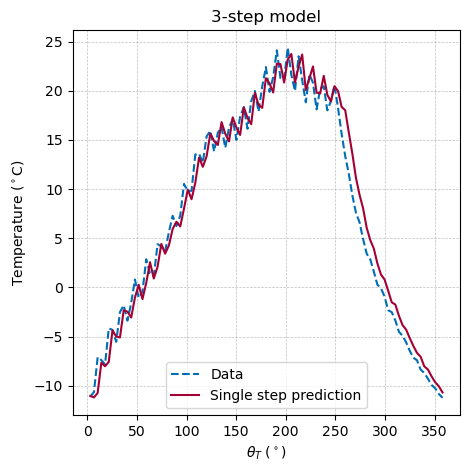

Mean error: -1.0541865534634924
Standard deviation: 1.1062351306101204


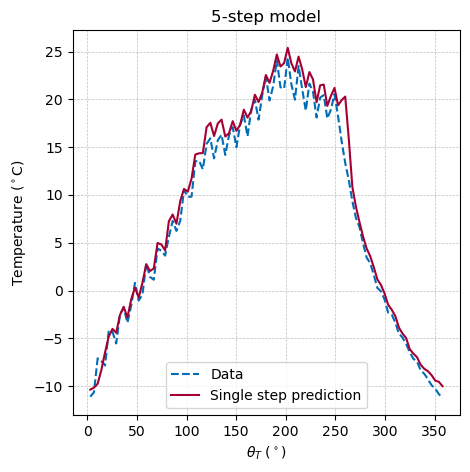

Mean error: -0.3276135056534983
Standard deviation: 1.3567190416861532


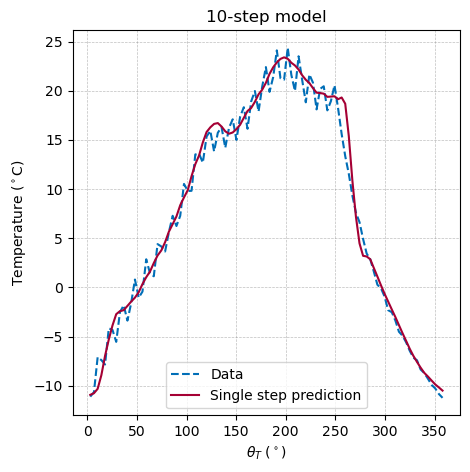

Mean error: -0.1825471797186064
Standard deviation: 1.3302813617531255


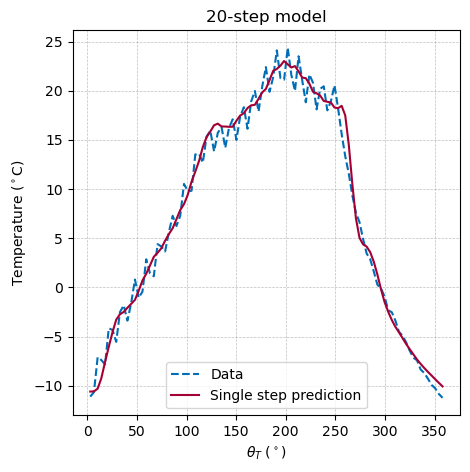

Mean error: -0.593499776960647
Standard deviation: 1.2251331254827584


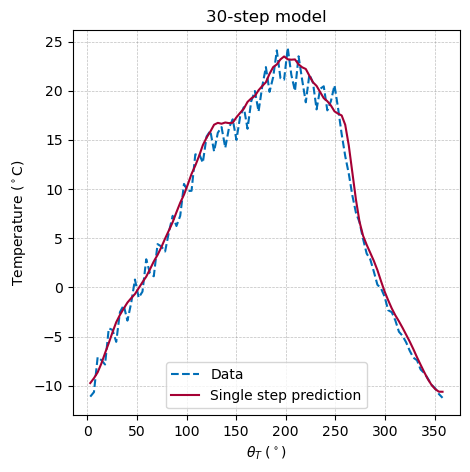

Mean error: 0.4585992262289707
Standard deviation: 1.3472994304704748


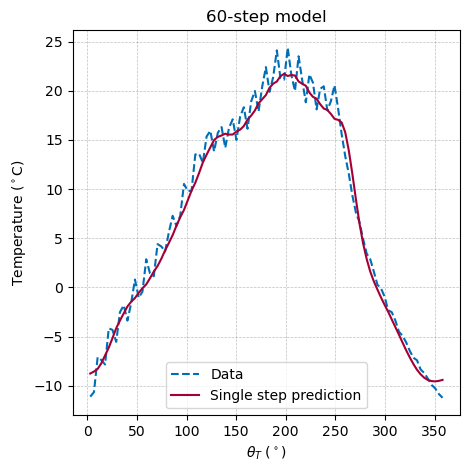

Mean error: 0.45806220171798073
Standard deviation: 1.238038714159538


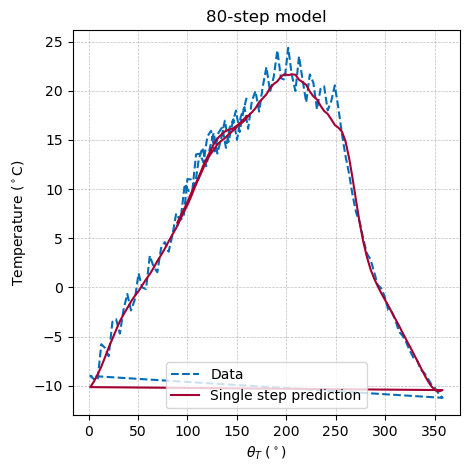

Mean error: 0.7834745665661348
Standard deviation: 1.3830424201392277


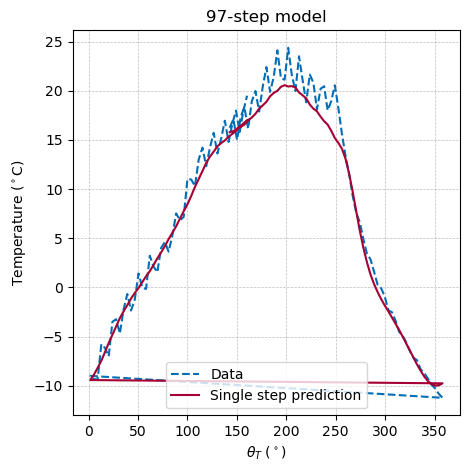

In [58]:
mean_3, std_3 = validate_model(
    model_3_step,
    test_df_3_step[89:186],
    3,
    min_temp,
    max_temp,
    "3-step model",
    plt_auto_reg=False,
)

mean_5, std_5 = validate_model(
    model_5_step,
    test_df_5_step[86:183],
    5,
    min_temp,
    max_temp,
    "5-step model",
    plt_auto_reg=False,
)

mean_10, std_10 = validate_model(
    model_10_step,
    test_df_10_step[78:175],
    10,
    min_temp,
    max_temp,
    "10-step model",
    plt_auto_reg=False,
)

# validate_model(
#     model_15_step,
#     test_df_15_step[70:167],
#     15,
#     min_temp,
#     max_temp,
#     "15-step model",
# )

mean_20, std_20 = validate_model(
    model_20_step,
    test_df_20_step[62:159],
    20,
    min_temp,
    max_temp,
    "20-step model",
    plt_auto_reg=False,
)

mean_30, std_30 = validate_model(
    model_30_step,
    test_df_30_step[47:144],
    30,
    min_temp,
    max_temp,
    "30-step model",
    plt_auto_reg=False,
)

mean_60, std_60 = validate_model(
    model_60_step,
    test_df_60_step[5:102],
    60,
    min_temp,
    max_temp,
    "60-step model",
    plt_auto_reg=False,
)

mean_80, std_80 = validate_model(
    model_80_step,
    test_df_80_step[:],
    80,
    min_temp,
    max_temp,
    "80-step model",
    plt_auto_reg=False,
)

mean_90, std_90 = validate_model(
    model_90_step,
    test_df_90_step[:],
    90,
    min_temp,
    max_temp,
    "97-step model",
    plt_auto_reg=False,
)


In [33]:
mean_

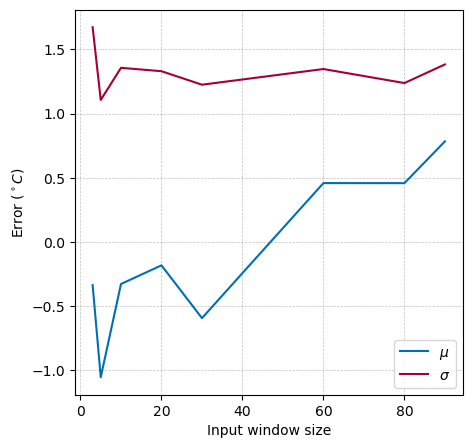

In [59]:
plt.figure(figsize=(5, 5))
plt.plot(
    [3, 5, 10, 20, 30, 60, 80, 90],
    [mean_3, mean_5, mean_10, mean_20, mean_30, mean_60, mean_80, mean_90] ,
    label=r"$\mu$",
    color=plt_colors[0]
)
plt.plot(
    [3, 5, 10, 20, 30, 60, 80, 90],
    [std_3, std_5, std_10, std_20, std_30, std_60, std_80, std_90],
    label=r"$\sigma$",
    color=plt_colors[1]
)
plt.xlabel("Input window size")
plt.ylabel(r"Error $(^\circ C)$")
plt.legend()
plt.grid()
plt.show()

Mean error: 1.3915357545302929
Standard deviation: 1.682321164163139


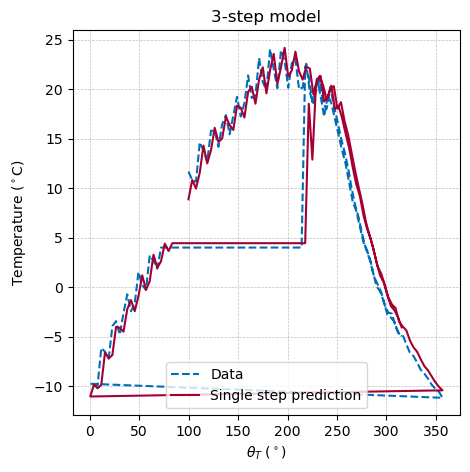

Mean error: 1.567524305312864
Standard deviation: 2.163009498007349


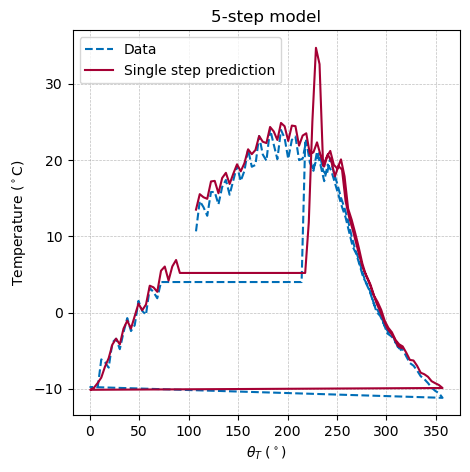

Mean error: 1.3202648837906976
Standard deviation: 2.346720306308868


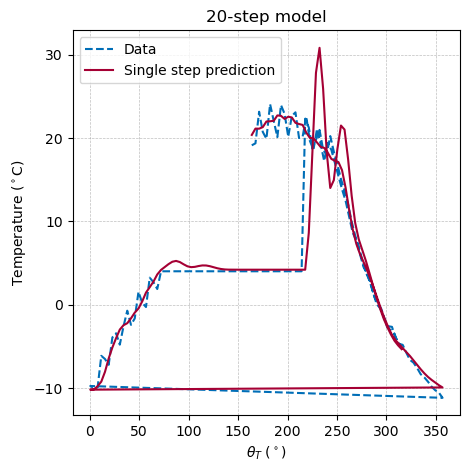

Mean error: 1.976038544691526
Standard deviation: 2.3474099430515705


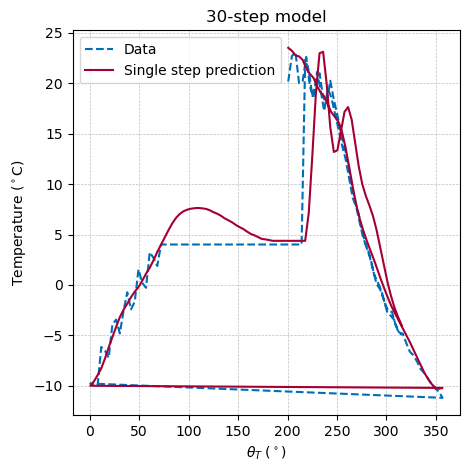

Mean error: 2.4644305281162264
Standard deviation: 2.4951962731271196


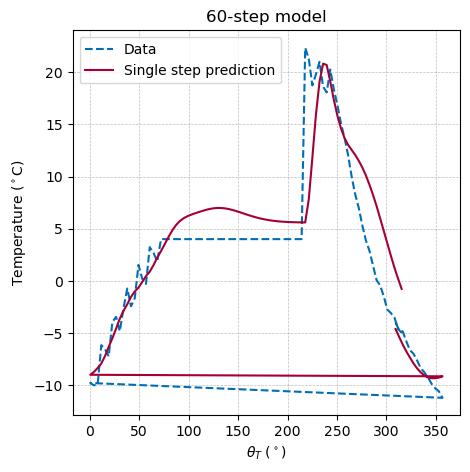

Mean error: 4.170550740650723
Standard deviation: 2.889598353386881


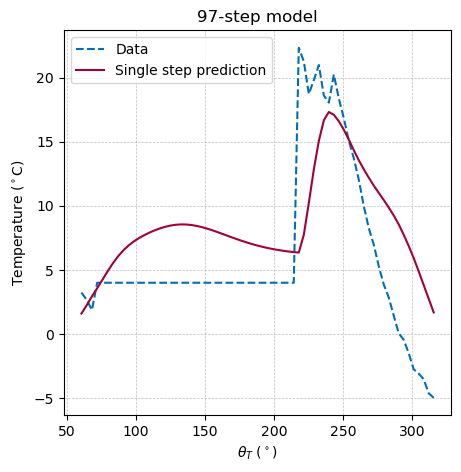

(4.170550740650723, 2.889598353386881)

In [48]:
# Testing the ability of the model to detect anomalies
# Extracting orbit data with known anomaly
anomaly_df = telem_df[400:560].copy()
anomaly_df = anomaly_df.reset_index(drop=True)
anomaly_df.loc[:, "black chassis temperature (deg C)":"solar panel -Y temperature (deg C)"] = (anomaly_df.loc[:, "black chassis temperature (deg C)":"solar panel -Y temperature (deg C)"] - min_temp) / (max_temp - min_temp)
# Creating new testing dataframe
anomaly_test_3_df = section_data(anomaly_df, 3)
anomaly_test_5_df = section_data(anomaly_df, 5)
anomaly_test_20_df = section_data(anomaly_df, 20)
anomaly_test_30_df = section_data(anomaly_df, 30)
anomaly_test_60_df = section_data(anomaly_df, 60)
anomaly_test_90_df = section_data(anomaly_df, 90)

# Plotting the anomaly
validate_model(
    model_3_step,
    anomaly_test_3_df,
    3,
    min_temp,
    max_temp,
    "3-step model",
    plt_auto_reg=False
)

validate_model(
    model_5_step,
    anomaly_test_5_df,
    5,
    min_temp, 
    max_temp,
    "5-step model",
    plt_auto_reg=False
)

validate_model(
    model_20_step,
    anomaly_test_20_df,
    20,
    min_temp, 
    max_temp,
    "20-step model",
    plt_auto_reg=False
)

validate_model(
    model_30_step,
    anomaly_test_30_df,
    30,
    min_temp, 
    max_temp,
    "30-step model",
    plt_auto_reg=False
)

validate_model(
    model_60_step,
    anomaly_test_60_df,
    60,
    min_temp, 
    max_temp,
    "60-step model",
    plt_auto_reg=False
)

validate_model(
    model_90_step,
    anomaly_test_90_df,
    90,
    min_temp,
    max_temp,
    "97-step model",
    plt_auto_reg=False
)

In [ ]:
# Testing the effect of amount of training data on model performance
# Creating new training and testing dataframes
train_30_new_df = telem_30_step_df[:74].copy()
x_train = np.empty((len(train_30_new_df), 30, 1), dtype=np.float64)
y_train = np.empty((len(train_30_new_df), 1), dtype=np.float64)
for i, row in train_30_new_df.iterrows():
    x_train[i, :, 0] = row[1:31]
    y_train[i, 0] = row[121]

x_test = np.empty((len(test_df_30_step), 30, 1), dtype=np.float64)
y_test = np.empty((len(test_df_30_step), 1), dtype=np.float64)
for i, row in test_df_30_step.iterrows():
    x_test[i, :, 0] = row[1:31]
    y_test[i, 0] = row[121]

# Creating new model
model_30_step_new = tf.keras.Sequential()
model_30_step_new.add(tf.keras.layers.LSTM(64, input_shape=(30, 1), return_sequences=True))
model_30_step_new.add(tf.keras.layers.LSTM(64, return_sequences=True))
model_30_step_new.add(tf.keras.layers.LSTM(64))
model_30_step_new.add(tf.keras.layers.Dense(1))

model_30_step_new.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.MeanAbsoluteError()],
)

# Training new model
model_30_step_new.fit(
    x_train,
    y_train,
    epochs=150,
    validation_data=(x_test, y_test),
)

In [ ]:
validate_model(
    model_30_step_new,
    test_df_30_step[47:144],
    30,
    min_temp,
    max_temp,
    "30-step model",
)

In [ ]:
# Creating a model independent of input sequence length
model_multi_step = tf.keras.Sequential()
model_multi_step.add(tf.keras.layers.LSTM(64, input_shape=(None, 1), return_sequences=True))
model_multi_step.add(tf.keras.layers.LSTM(64, return_sequences=True))
model_multi_step.add(tf.keras.layers.LSTM(64))
model_multi_step.add(tf.keras.layers.Dense(1))

model_multi_step.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.MeanAbsoluteError()],
)

# Training model on 5-step data
model_multi_step = create_model(5, telem_5_step_df, 25, create_new_model=False, input_model=model_multi_step)


# Training model on 20-step data
model_multi_step = create_model(20, telem_20_step_df, 75, create_new_model=False, input_model=model_multi_step)

# Training model on 30-step data
model_multi_step = create_model(30, telem_30_step_df, 75, create_new_model=False, input_model=model_multi_step)

In [ ]:
validate_model(
    model_multi_step,
    test_df_5_step[86:183],
    5,
    min_temp,
    max_temp,
    "5-step model",
)

validate_model(
    model_multi_step,
    test_df_20_step[62:159],
    20,
    min_temp,
    max_temp,
    "20-step model",
)

validate_model(
    model_multi_step,
    test_df_30_step[47:144],
    30,
    min_temp,
    max_temp,
    "30-step model",
)

In [ ]:
# Create a model that predcicts four temperature channels

train_multi_channel_df = telem_30_step_df[:int(len(telem_30_step_df) * 0.8)].copy()
test_multi_channel_df = telem_30_step_df[int(len(telem_30_step_df) * 0.8):].copy().reset_index(drop=True)

x_train = np.empty((len(train_multi_channel_df), 30, 4), dtype=np.float64)
y_train = np.empty((len(train_multi_channel_df), 4), dtype=np.float64)
for i, row in train_multi_channel_df.iterrows():
    x_train[i, :, 0] = row[1:31]
    x_train[i, :, 1] = row[31:61]
    x_train[i, :, 2] = row[61:91]
    x_train[i, :, 3] = row[91:121]

    y_train[i] = row[121:125]

x_test = np.empty((len(test_multi_channel_df), 30, 4), dtype=np.float64)
y_test = np.empty((len(test_multi_channel_df), 4), dtype=np.float64)
for i, row in test_multi_channel_df.iterrows():
    x_test[i, :, 0] = row[1:31]
    x_test[i, :, 1] = row[31:61]
    x_test[i, :, 2] = row[61:91]
    x_test[i, :, 3] = row[91:121]

    y_test[i] = row[121:125]

model_multi_channel = tf.keras.Sequential()
model_multi_channel.add(tf.keras.layers.LSTM(128, input_shape=(None, 4), return_sequences=True, ))
model_multi_channel.add(tf.keras.layers.LSTM(128, return_sequences=True, ))
model_multi_channel.add(tf.keras.layers.LSTM(64, return_sequences=True, ))
model_multi_channel.add(tf.keras.layers.LSTM(32, return_sequences=True, ))
model_multi_channel.add(tf.keras.layers.LSTM(16, ))

model_multi_channel.add(tf.keras.layers.Dense(4))

model_multi_channel.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.MeanAbsoluteError()],
)

model_multi_channel.summary()

_ = model_multi_channel.fit(
    x_train,
    y_train,
    epochs=100,
    validation_data=(x_test, y_test),
)


In [ ]:
# Single step prediction
pred_start = 47
pred_end = 144

# Checking the ability of the model to detect anomalies
x_test = np.empty(shape=(anomaly_test_30_df.shape[0], 30, 4))
y_test = np.empty(shape=(anomaly_test_30_df.shape[0], 4))
for i, row in anomaly_test_30_df.iterrows():
    x_test[i, :, 0] = row[1:31]
    x_test[i, :, 1] = row[31:61]
    x_test[i, :, 2] = row[61:91]
    x_test[i, :, 3] = row[91:121]

    y_test[i] = row[121:125]
y_pred_single = model_multi_channel.predict(x_test[pred_start:pred_end, :, :], verbose=False)

# Auto-regressive predictions
x_pred_auto_reg = np.empty((pred_end-pred_start, 30, 4), dtype=np.float64)
y_pred_auto_reg = np.empty((pred_end-pred_start, 4), dtype=np.float64)
x_pred_auto_reg[0] = x_test[pred_start]
for i in range(pred_end-pred_start):
    y_pred_auto_reg[i] = model_multi_channel.predict(x_pred_auto_reg[i, :, :].reshape(1, 30, 4), verbose=False)
    if i == pred_end-pred_start-1:
        break
    x_pred_auto_reg[i+1, :-1, :] = x_pred_auto_reg[i, 1:, :]
    x_pred_auto_reg[i+1, -1, :] = y_pred_auto_reg[i]

# Plotting predictions
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(
    test_multi_channel_df["theta_T"][pred_start:pred_end],
    y_test[pred_start:pred_end, 0] * (max_temp - min_temp) + min_temp, 
    color=plt_colors[0],
    label="Data",
)
plt.plot(
    test_multi_channel_df["theta_T"][pred_start:pred_end],
    y_pred_single[:, 0] * (max_temp - min_temp) + min_temp,
    color=plt_colors[1],
    label="Single step prediction",
    linestyle="--",
    linewidth=2,
)
plt.plot(
    test_multi_channel_df["theta_T"][pred_start:pred_end],
    y_pred_auto_reg[:, 0] * (max_temp - min_temp) + min_temp,
    color=plt_colors[2],
    label="Auto-regressive prediction",
    linestyle="--",
    linewidth=2,
)
plt.xlabel(r"$\theta_T\;(^\circ)$")
plt.ylabel("Temperature ($^\circ$C)")
plt.title("Black chassis")
plt.legend()
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(
    test_multi_channel_df["theta_T"][pred_start:pred_end],
    y_test[pred_start:pred_end, 1] * (max_temp - min_temp) + min_temp,
    color=plt_colors[0],
    label="Data",
)
plt.plot(
    test_multi_channel_df["theta_T"][pred_start:pred_end],
    y_pred_single[:, 1] * (max_temp - min_temp) + min_temp,
    color=plt_colors[1],
    label="Single step prediction",
    linestyle="--",
    linewidth=2,
)
plt.plot(
    test_multi_channel_df["theta_T"][pred_start:pred_end],
    y_pred_auto_reg[:, 1] * (max_temp - min_temp) + min_temp,
    color=plt_colors[2],
    label="Auto-regressive prediction",
    linestyle="--",
    linewidth=2,
)
plt.xlabel(r"$\theta_T\;(^\circ)$")
plt.ylabel("Temperature ($^\circ$C)")
plt.title("Silver chassis")
plt.legend()
plt.grid()

plt.subplot(2, 2, 3)
plt.plot(
    test_multi_channel_df["theta_T"][pred_start:pred_end],
    y_test[pred_start:pred_end, 2] * (max_temp - min_temp) + min_temp,
    color=plt_colors[0],
    label="Data",
)
plt.plot(
    test_multi_channel_df["theta_T"][pred_start:pred_end],
    y_pred_single[:, 2] * (max_temp - min_temp) + min_temp,
    color=plt_colors[1],
    label="Single step prediction",
    linestyle="--",
    linewidth=2,
)
plt.plot(
    test_multi_channel_df["theta_T"][pred_start:pred_end],
    y_pred_auto_reg[:, 2] * (max_temp - min_temp) + min_temp,
    color=plt_colors[2],
    label="Auto-regressive prediction",
    linestyle="--",
    linewidth=2,
)
plt.xlabel(r"$\theta_T\;(^\circ)$")
plt.ylabel("Temperature ($^\circ$C)")
plt.title("Black panel")
plt.legend()
plt.grid()

plt.subplot(2, 2, 4)
plt.plot(
    test_multi_channel_df["theta_T"][pred_start:pred_end],
    y_test[pred_start:pred_end, 3] * (max_temp - min_temp) + min_temp,
    color=plt_colors[0],
    label="Data",
)
plt.plot(
    test_multi_channel_df["theta_T"][pred_start:pred_end],
    y_pred_single[:, 3] * (max_temp - min_temp) + min_temp,
    color=plt_colors[1],
    label="Single step prediction",
    linestyle="--",
    linewidth=2,
)
plt.plot(
    test_multi_channel_df["theta_T"][pred_start:pred_end],
    y_pred_auto_reg[:, 3] * (max_temp - min_temp) + min_temp,
    color=plt_colors[2],
    label="Auto-regressive prediction",
    linestyle="--",
    linewidth=2,
)
plt.xlabel(r"$\theta_T\;(^\circ)$")
plt.ylabel("Temperature ($^\circ$C)")
plt.title("Silver panel")
plt.legend()
plt.grid()

plt.show()
plt.close()

In [ ]:
anomaly_df = telem_df[444:572].copy()
anomaly_df = anomaly_df.reset_index(drop=True)
anomaly_df.loc[:, "black chassis temperature (deg C)":"solar panel -Y temperature (deg C)"] = (anomaly_df.loc[:, "black chassis temperature (deg C)":"solar panel -Y temperature (deg C)"] - min_temp) / (max_temp - min_temp)
anomaly_test_30_df = section_data(anomaly_df, 30)

# Checking the ability of the model to detect anomalies
x_test = np.empty(shape=(anomaly_test_30_df.shape[0], 30, 4))
y_test = np.empty(shape=(anomaly_test_30_df.shape[0], 4))
for i, row in anomaly_test_30_df.iterrows():
    x_test[i, :, 0] = row[1:31]
    x_test[i, :, 1] = row[31:61]
    x_test[i, :, 2] = row[61:91]
    x_test[i, :, 3] = row[91:121]

    y_test[i] = row[121:125]

y_pred_single = model_multi_channel.predict(x_test)

In [ ]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(
    anomaly_test_30_df["theta_T"],
    y_test[:, 0] * (max_temp - min_temp) + min_temp,
    color=plt_colors[0],
    label="Data",
)
plt.plot(
    anomaly_test_30_df["theta_T"],
    y_pred_single[:, 0] * (max_temp - min_temp) + min_temp,
    color=plt_colors[1],
    label="Single step prediction",
    linestyle="--",
    linewidth=2,
)
plt.xlabel(r"$\theta_T\;(^\circ)$")
plt.ylabel("Temperature ($^\circ$C)")
plt.title("Black chassis")
plt.legend()
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(
    anomaly_test_30_df["theta_T"],
    y_test[:, 1] * (max_temp - min_temp) + min_temp,
    color=plt_colors[0],
    label="Data",
)
plt.plot(
    anomaly_test_30_df["theta_T"],
    y_pred_single[:, 1] * (max_temp - min_temp) + min_temp,
    color=plt_colors[1],
    label="Single step prediction",
    linestyle="--",
    linewidth=2,
)
plt.xlabel(r"$\theta_T\;(^\circ)$")
plt.ylabel("Temperature ($^\circ$C)")
plt.title("Silver chassis")
plt.legend()
plt.grid()

plt.subplot(2, 2, 3)
plt.plot(
    anomaly_test_30_df["theta_T"],
    y_test[:, 2] * (max_temp - min_temp) + min_temp,
    color=plt_colors[0],
    label="Data",
)
plt.plot(
    anomaly_test_30_df["theta_T"],
    y_pred_single[:, 2] * (max_temp - min_temp) + min_temp,
    color=plt_colors[1],
    label="Single step prediction",
    linestyle="--",
    linewidth=2,
)
plt.xlabel(r"$\theta_T\;(^\circ)$")
plt.ylabel("Temperature ($^\circ$C)")
plt.title("Black panel")
plt.legend()
plt.grid()

plt.subplot(2, 2, 4)
plt.plot(
    anomaly_test_30_df["theta_T"],
    y_test[:, 3] * (max_temp - min_temp) + min_temp,
    color=plt_colors[0],
    label="Data",
)
plt.plot(
    anomaly_test_30_df["theta_T"],
    y_pred_single[:, 3] * (max_temp - min_temp) + min_temp,
    color=plt_colors[1],
    label="Single step prediction",
    linestyle="--",
    linewidth=2,
)
plt.xlabel(r"$\theta_T\;(^\circ)$")
plt.ylabel("Temperature ($^\circ$C)")
plt.title("Silver panel")
plt.legend()
plt.grid()

plt.suptitle("Anomaly detection")
plt.show()
plt.close()